# Translate image to corresponding alphabhet using pre-trained model

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing import image
import numpy as np
import pandas as pd
from pathlib import Path
import imutils
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import pyttsx3;
%matplotlib inline




Using TensorFlow backend.


In [17]:
IMAGE_SIZE = 50 #We'll be workign with 50 * 50 pixel images
LABELS = [chr(c) for c in range(ord('A'), ord('Z') + 1)]
LABELS.append("nothing")
LABELS.append("space")
engine = pyttsx3.init();
engine.setProperty('rate', 105)
engine.setProperty('voice', 1)
MODEL_PATH = "trained_model\my_model.h5"

In [3]:
from keras.models import load_model
model = load_model(MODEL_PATH)

In [5]:
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 50, 50, 50)        500       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 50)        22550     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 50)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 24, 50)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 100)       45100     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 22, 100)       90100     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 100)       0         
__________

The predicted letter is W with confidence percentage 69.44100189208984%


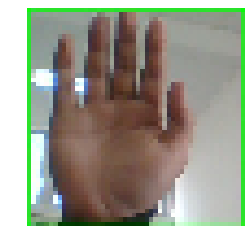

In [4]:
IMG_PATH = "test.jpg"

def preprocess_image(IMG_PATH):
    """returns image array by preprocessing the image
    Keyword arguments:
    IMG_PATH: path of the image
    Example: img_array = preprocess_image("a.jpg")
    """
    try:
        #Load image with target size and convert img to array
        img = image.load_img(IMG_PATH, target_size = (IMAGE_SIZE,IMAGE_SIZE))
        plt.axis('off')
        plt.imshow(img)
        img_array = image.img_to_array(img)
       # imutils.resize(img,IMAGE_SIZE,IMAGE_SIZE)
        #Change color sapce to gray
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

        #Reshape array to l * w * channels
        img_array = img_array.reshape(IMAGE_SIZE, IMAGE_SIZE, 1)
        
        #Normalize th array
        img_array /= 225.0
        
        #Expand Dimension of the array as our model expects a 4D array
        img_array = np.expand_dims(img_array, axis = 0)
        return img_array
        
    except Exception as e:
        print(e)
        return None
    

def which_letter(IMG_PATH):
    """returns confident_percent, predicted label using the model or None if exception occurs
    Keyword arguments:
    IMG_PATH: path of the image
    eg:
        print(which_letter("sample.jpeg"))
    """
    try:
        img_array = preprocess_image(IMG_PATH)
        preds = model.predict(img_array)
        most_likely_class_index = int(np.argmax(preds))
        
        np.set_printoptions(suppress = True, precision = 4)
        preds *= 100
        #print(preds)
        return preds.max(), LABELS[most_likely_class_index]
    except Exception as e:
        print(e)
        return None

confident_percent, predicted_label = which_letter(IMG_PATH)
if confident_percent is not None:
    print("The predicted letter is {} with confidence percentage {}%".format(predicted_label, confident_percent))




In [5]:
def pre_process(img_array):
    
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    img_array = cv2.resize(img_array, (50, 50))
    #Reshape array to l * w * channels
    img_array = img_array.reshape(IMAGE_SIZE, IMAGE_SIZE, 1)

    #Normalize th array
    img_array = img_array / 255.0

    #Expand Dimension of the array as our model expects a 4D array
    img_array = np.expand_dims(img_array, axis = 0)
    return img_array

def which(img_array):
   
    img_array = pre_process(img_array)
    preds = model.predict(img_array)
    most_likely_class_index = int(np.argmax(preds))
    np.set_printoptions(suppress = True, precision = 4)
    preds *= 100
    #print(preds)
    return preds.max(), LABELS[most_likely_class_index]
 

img_array = cv2.imread("P_test.jpg")
percent, label = which(img_array)
print(percent, label)

100.0 P


# Get Frames from Webcam and translate

In [29]:
window_name = "ASL"
frame_height, frame_width, roi_height, roi_width = 480, 900, 600, 300
 
def getMaxContour(contours, minArea = -1):
    maxC = None
    maxArea = minArea
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if(area > maxArea):
            maxArea = area
            maxC = cnt
    return maxC



cap = cv2.VideoCapture(0)
cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
#cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
sentence = ""
while True:
    ret, frame = cap.read()
    if ret is None:
        print("No Frame Captured")
        continue
        
    #frame = cv2.resize(frame, (0, 0))
    cv2.rectangle(frame,(0, 0),(roi_width, roi_height),(255,0,0), 3) # bounding box which captures ASL sign to be detected by the system
    img1 = frame[0: roi_height, 0: roi_width]
    
    img_ycrcb = cv2.cvtColor(img1, cv2.COLOR_BGR2YCR_CB)
    blur = cv2.GaussianBlur(img_ycrcb ,(11,11),0)
    
    #lower  and upper skin color
    skin_ycrcb_min = np.array((0, 138, 67))
    skin_ycrcb_max = np.array((255, 173, 133))
    
    mask = cv2.inRange(blur, skin_ycrcb_min, skin_ycrcb_max)  # detecting the hand in the bounding box using skin detection
    
    kernel = np.ones((2, 2), dtype = np.uint8)
    mask = cv2.dilate(mask, kernel, iterations = 1)
    
    _, contours, _ = cv2.findContours(mask.copy(),cv2.RETR_EXTERNAL, 2) 
    cnt= getMaxContour(contours, minArea = 2000)
    naya = cv2.bitwise_and(img1, img1, mask = mask)
    cv2.imshow("mask", mask)
    x, y, w, h = cv2.boundingRect(cnt)
    
    #Centre cropping the image
    x_start, y_start, x_end, y_end = 0, 0, 0, 0
    mx = 0
    if w > 0 and h > 0:
        mx = max(w, h, 150)
        if x + 7 * mx // 8 > roi_width and y + mx > roi_height:
            mx = max(roi_width - x, roi_height - y, 150)
            x_start, x_end = roi_width - mx, roi_width
            y_start, y_end = roi_height - mx, roi_height
            
        elif y + mx > roi_height and x == 0:
            mx = max(w, roi_height - y, 150)
            x_start, x_end = x, x + mx
            y_start, y_end = roi_height - mx, roi_height
        elif y + mx > roi_height:
            mx = max(w, roi_height - y, 150)
            x_start, x_end = x - mx // 8, x + 7 * mx // 8
            y_start, y_end = roi_height - mx, roi_height
        elif x + 7 * mx // 8 > roi_width:
            mx = max(roi_width - x, h, 150)
            x_start, x_end = roi_width - mx, roi_width
            y_start, y_end = y, y + mx
        elif x == 0:
            x_start, x_end = 0, mx
            y_start, y_end = y, y + mx
        else:
            x_start, x_end = x - mx // 8, x + 7 * mx // 8
            y_start, y_end = y, y + mx
        
    
    #Draw Green Square around the hand
    cv2.rectangle(img1, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)      
   

    #cv2.imshow('img1', img1)
    #cv2.imshow("mask", mask)
    cv2.imshow("naya", naya)
    hand_bg_rm = naya[y_start: y_end, x_start: x_end]
    hand = img1[y_start: y_end, x_start: x_end]
    #roi_capture = frame[0: ]
    #Control Key
    c = cv2.waitKey(1) & 0xff
    
    #Speak the sentence
    if len(sentence) > 0 and c == ord('s'):
        engine.say(sentence)
        engine.runAndWait() 
    #Clear the sentence
    if c == ord('c'):
        sentence = ""
    #Delete the last character
    if c == ord('d'):
        sentence = sentence[:-1]
            
    #If  valid hand area is cropped
    if hand.shape[0] != 0 and hand.shape[1] != 0:
        conf, label = which(hand)
        
        conf, label1 = which(hand_bg_rm)
        cv2.putText(frame, label,(50, 50),cv2.FONT_HERSHEY_COMPLEX_SMALL, .7,(0,0,255))
        if c == ord('n'):
            if label == "nothing":
                pass
            elif label == "space":
                sentence += " "
            else:
                sentence += label
        
        
       
            
    cv2.putText(frame, sentence, (50, 70), cv2.FONT_HERSHEY_COMPLEX_SMALL, .7, (0, 0, 255))
    cv2.imshow(window_name,frame)
    
    if c == 32:
        if hand.shape[0] == hand.shape[1] + 1:
            hand =  img1[y_start: y_end, x_start: x_end + 1]
        elif hand.shape[1] == hand.shape[0] + 1:
             hand =  img1[y_start: y_end + 1, x_start: x_end]            
        elif hand.shape[0] != hand.shape[1]:
            print(hand.shape)
            print("Outside ROI")
            continue
        cv2.imwrite("test.jpg", hand)
        #cv2.imwrite("frame_captured.jpg",)
        #cv2.rectangle(frame,(0, 0),(roi_width, roi_height),(255,0,0), 3)
        cv2.imwrite("test_bg_less.jpg", hand_bg_rm)
        cv2.imwrite("detect.jpg", img1)
    if c == 27:
        break
cap.release()
cv2.destroyAllWindows()

# TO DOS

1. Creating and training datasets
2. Code refactoring

The predicted letter is C with confidence percentage 80.26942443847656%.


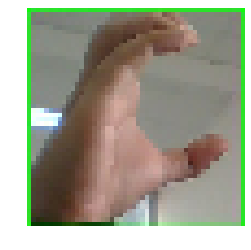

In [8]:
confidence_w_bg, label = which_letter("test.jpg")
print("The predicted letter is {} with confidence percentage {}%.".format(label, confidence_w_bg))